# 手寫阿拉伯數字辨識 完整版

## 載入套件

In [1]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

## 設定參數

In [2]:
PATH_DATASETS = "" # 預設路徑
BATCH_SIZE = 1024  # 批量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

## 步驟1：載入 MNIST 手寫阿拉伯數字資料

In [3]:
# 下載 MNIST 手寫阿拉伯數字 訓練資料
train_ds = MNIST(PATH_DATASETS, train=True, download=True, 
                 transform=transforms.ToTensor())

# 下載測試資料
test_ds = MNIST(PATH_DATASETS, train=False, download=True, 
                 transform=transforms.ToTensor())

# 訓練/測試資料的維度
print(train_ds.data.shape, test_ds.data.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


In [4]:
# 訓練資料前10筆圖片的數字
train_ds.targets[:10]

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])

In [5]:
# 顯示第1張圖片內含值
train_ds.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [6]:
# 將非0的數字轉為1，顯示第1張圖片
data = train_ds.data[0].clone()
data[data>0]=1
data = data.numpy()

# 將轉換後二維內容顯示出來，隱約可以看出數字為 5
text_image=[]
for i in range(data.shape[0]):
    text_image.append(''.join(data[i].astype(str)))
text_image

['0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000001111111111110000',
 '0000000011111111111111110000',
 '0000000111111111111111100000',
 '0000000111111111110000000000',
 '0000000011111110110000000000',
 '0000000001111100000000000000',
 '0000000000011110000000000000',
 '0000000000011110000000000000',
 '0000000000001111110000000000',
 '0000000000000111111000000000',
 '0000000000000011111100000000',
 '0000000000000001111100000000',
 '0000000000000000011110000000',
 '0000000000000011111110000000',
 '0000000000001111111100000000',
 '0000000000111111111000000000',
 '0000000011111111110000000000',
 '0000001111111111000000000000',
 '0000111111111100000000000000',
 '0000111111110000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000']

In [7]:
# 將非0的數字轉為1，顯示第2張圖片
data = train_ds.data[1].clone()
data[data>0]=1
data = data.numpy()

# 將轉換後二維內容顯示出來，隱約可以看出數字為 5
text_image=[]
for i in range(data.shape[0]):
    text_image.append(''.join(data[i].astype(str)))
text_image

['0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000001111100000000',
 '0000000000000011111100000000',
 '0000000000000111111111000000',
 '0000000000011111111111000000',
 '0000000000011111111111000000',
 '0000000000111111111111000000',
 '0000000001111111110011100000',
 '0000000011111100000011100000',
 '0000000111111100000011100000',
 '0000000111100000000011100000',
 '0000000111000000000011100000',
 '0000001111000000000011100000',
 '0000001111000000001111100000',
 '0000001110000000011111000000',
 '0000001110000000111100000000',
 '0000001110000001111000000000',
 '0000001111111111111000000000',
 '0000001111111111100000000000',
 '0000001111111110000000000000',
 '0000000111111100000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000']

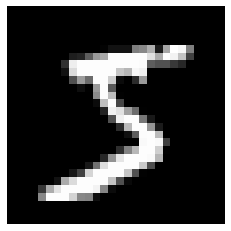

In [8]:
# 顯示第1張圖片圖像
import matplotlib.pyplot as plt

# 第一筆資料
X = train_ds.data[0]

# 繪製點陣圖，cmap='gray':灰階
plt.imshow(X.reshape(28,28), cmap='gray')

# 隱藏刻度
plt.axis('off') 

# 顯示圖形
plt.show() 

## 步驟2：資料清理，此步驟無需進行

## 步驟3：特徵工程，此步驟無需進行

In [9]:
# train_ds.data = train_ds.data / 255.0
# test_ds.data = test_ds.data / 255.0

## 步驟4：資料分割，此步驟無需進行，載入MNIST資料時，已經切割好了

## 步驟5：建立模型結構

In [10]:
# 建立模型
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28 * 28, 256), 
    torch.nn.Dropout(0.2),
    torch.nn.Linear(256, 10), 
    # 使用nn.CrossEntropyLoss()時，不需要將輸出經過softmax層，否則計算的損失會有誤
    # torch.nn.Softmax(dim=1)
).to(device)

## 步驟6：結合訓練資料及模型，進行模型訓練

In [11]:
epochs = 5
lr=0.1

# 建立 DataLoader
train_loader = DataLoader(train_ds, batch_size=600)

# 設定優化器(optimizer)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

model.train()
loss_list = []    
for epoch in range(1, epochs + 1):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
#         if batch_idx == 0 and epoch == 1: print(data[0])

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            loss_list.append(loss.item())
            batch = batch_idx * len(data)
            data_count = len(train_loader.dataset)
            percentage = (100. * batch_idx / len(train_loader))
            print(f'Epoch {epoch}: [{batch:5d} / {data_count}] ({percentage:.0f} %)' +
                  f'  Loss: {loss.item():.6f}')

Epoch 1: [    0 / 60000] (0 %)  Loss: 2.299004
Epoch 1: [ 6000 / 60000] (10 %)  Loss: 1.999201
Epoch 1: [12000 / 60000] (20 %)  Loss: 1.785167
Epoch 1: [18000 / 60000] (30 %)  Loss: 1.549837
Epoch 1: [24000 / 60000] (40 %)  Loss: 1.336522
Epoch 1: [30000 / 60000] (50 %)  Loss: 1.223380
Epoch 1: [36000 / 60000] (60 %)  Loss: 0.995878
Epoch 1: [42000 / 60000] (70 %)  Loss: 0.974807
Epoch 1: [48000 / 60000] (80 %)  Loss: 0.716661
Epoch 1: [54000 / 60000] (90 %)  Loss: 0.739871
Epoch 2: [    0 / 60000] (0 %)  Loss: 0.694784
Epoch 2: [ 6000 / 60000] (10 %)  Loss: 0.549597
Epoch 2: [12000 / 60000] (20 %)  Loss: 0.641719
Epoch 2: [18000 / 60000] (30 %)  Loss: 0.556501
Epoch 2: [24000 / 60000] (40 %)  Loss: 0.570708
Epoch 2: [30000 / 60000] (50 %)  Loss: 0.628632
Epoch 2: [36000 / 60000] (60 %)  Loss: 0.507579
Epoch 2: [42000 / 60000] (70 %)  Loss: 0.616338
Epoch 2: [48000 / 60000] (80 %)  Loss: 0.417794
Epoch 2: [54000 / 60000] (90 %)  Loss: 0.462503
Epoch 3: [    0 / 60000] (0 %)  Loss: 0.46

## 對訓練過程的損失繪圖

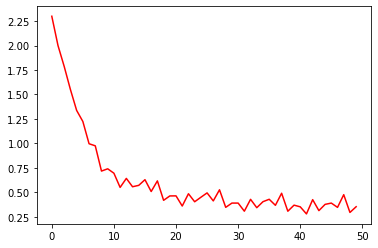

In [12]:
import matplotlib.pyplot as plt

plt.plot(loss_list, 'r')

## 步驟7：評分(Score Model)

In [13]:
# 建立 DataLoader
test_loader = DataLoader(test_ds, shuffle=False, batch_size=BATCH_SIZE)

model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        
        # sum up batch loss
        test_loss += criterion(output, target).item()
        
        # 預測
        pred = output.argmax(dim=1, keepdim=True)  
        
        # 正確筆數
        correct += pred.eq(target.view_as(pred)).sum().item()

# 平均損失
test_loss /= len(test_loader.dataset)
# 顯示測試結果
batch = batch_idx * len(data)
data_count = len(test_loader.dataset)
percentage = 100. * correct / data_count
print(f'平均損失: {test_loss:.4f}, 準確率: {correct}/{data_count}' + 
      f' ({percentage:.0f}%)\n')

平均損失: 0.0003, 準確率: 9055/10000 (91%)



## 實際比對測試資料的前20筆

In [14]:
# 實際預測 20 筆資料
predictions = []
with torch.no_grad():
    for i in range(20):
        data, target = test_ds[i][0], test_ds[i][1]
        data = data.reshape(1, *data.shape).to(device)
        output = torch.argmax(model(data), axis=-1)
        predictions.append(str(output.item()))

# 比對
print('actual    :', test_ds.targets[0:20].numpy())
print('prediction: ', ' '.join(predictions[0:20]))

actual    : [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
prediction:  7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4


In [15]:
# 顯示第 9 筆的機率
import numpy as np

i=8
data = test_ds[i][0]
data = data.reshape(1, *data.shape).to(device)
#print(data.shape)
predictions = torch.softmax(model(data), dim=1)
print(f'0~9預測機率: {np.around(predictions.cpu().detach().numpy(), 2)}')
print(f'0~9預測機率: {np.argmax(predictions.cpu().detach().numpy(), axis=-1)}')

0~9預測機率: [[0.01 0.   0.06 0.   0.04 0.01 0.86 0.   0.01 0.  ]]
0~9預測機率: [6]


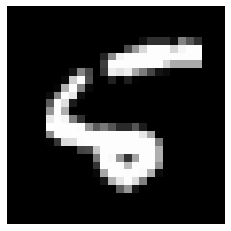

In [16]:
# 顯示第 9 筆圖像
X2 = test_ds[i][0] 
plt.imshow(X2.reshape(28,28), cmap='gray')
plt.axis('off')
plt.show() 

## 步驟8：評估，暫不進行

## 步驟9：模型佈署

In [17]:
# 模型存檔
torch.save(model, 'model.pt')

# 模型載入
model = torch.load('model.pt')

In [18]:
# 權重存檔
torch.save(model.state_dict(), 'model.pth')

# 權重載入
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [19]:
# 顯示每一層的 state_dict 維度
print("每一層的 state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

每一層的 state_dict:
1.weight 	 torch.Size([256, 784])
1.bias 	 torch.Size([256])
3.weight 	 torch.Size([10, 256])
3.bias 	 torch.Size([10])


## 步驟10：新資料預測

In [20]:
# 使用小畫家，繪製 0~9，實際測試看看
from skimage import io
from skimage.transform import resize
import numpy as np

# 讀取影像並轉為單色
for i in range(10):
    uploaded_file = f'./myDigits/{i}.png'
    image1 = io.imread(uploaded_file, as_gray=True)

    # 縮為 (28, 28) 大小的影像
    image_resized = resize(image1, (28, 28), anti_aliasing=True)    
    X1 = image_resized.reshape(1,28, 28) 

    # 反轉顏色，顏色0為白色，與 RGB 色碼不同，它的 0 為黑色
    X1 = torch.FloatTensor(1.0-X1).to(device)

    # 預測
    predictions = torch.softmax(model(X1), dim=1)
    # print(np.around(predictions.cpu().detach().numpy(), 2))
    print(f'actual/prediction: {i} {np.argmax(predictions.detach().cpu().numpy())}')

actual/prediction: 0 0
actual/prediction: 1 1
actual/prediction: 2 2
actual/prediction: 3 7
actual/prediction: 4 4
actual/prediction: 5 5
actual/prediction: 6 6
actual/prediction: 7 1
actual/prediction: 8 8
actual/prediction: 9 8


## 其他：顯示模型彙總資訊(summary)、繪製圖形顯示模型結構

In [21]:
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=256, bias=True)
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=256, out_features=10, bias=True)
)


In [22]:
# 顯示模型的彙總資訊
for name, module in model.named_children():
    print(f'{name}: {module}')

0: Flatten(start_dim=1, end_dim=-1)
1: Linear(in_features=784, out_features=256, bias=True)
2: Dropout(p=0.2, inplace=False)
3: Linear(in_features=256, out_features=10, bias=True)


In [25]:
!pip install torchinfo 

In [24]:
from torchinfo import summary
summary(model, (60000, 28, 28)) # input dimension size

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               --                        --
├─Flatten: 1-1                           [60000, 784]              --
├─Linear: 1-2                            [60000, 256]              200,960
├─Dropout: 1-3                           [60000, 256]              --
├─Linear: 1-4                            [60000, 10]               2,570
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
Total mult-adds (G): 12.21
Input size (MB): 188.16
Forward/backward pass size (MB): 127.68
Params size (MB): 0.81
Estimated Total Size (MB): 316.65

## PyTorch 無法繪製模型